Reading Standard calibration media extended

In [1]:
# importing everitying
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import physics

In [2]:
# reading the data form the excel file
df = pd.read_excel('../Standard calibration in culture media_extended.xlsx', sheet_name='Raw data', )
df.head()

,E0_Blank_culture media MH - moving average baseline,Unnamed: 1,Pyo 100 uM_MH - moving average baseline,Unnamed: 3,Unnamed: 4,Pyo 50 uM_MH - moving average baseline,Unnamed: 6,Unnamed: 7,Pyo 25 uM_MH - moving average baseline,Unnamed: 9,...,Unnamed: 32,Unnamed: 33,Pyo 0.25 uM_MH - moving average baseline,Unnamed: 35,Unnamed: 36,Pyo 0.1 uM_MH - moving average baseline,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
0,V,µA,µA,µA,µA,µA,µA,µA,µA,µA,...,µA,µA,µA,µA,µA,µA,µA,µA,µA,µA
1,-0.600097,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.595262,0.063593,0.098656,0.109374,0.115718,0.082966,0.110628,0.104234,0.088812,0.082304,...,0.079479,0.075286,0.075833,0.076125,0.079187,0.083927,0.078385,0.110979,0.051843,0.066755
3,-0.590427,0.054031,0.121318,0.130725,0.148006,0.099352,0.122679,0.113728,0.090737,0.073225,...,0.04127,0.070401,0.071166,0.054775,0.054862,0.065697,0.060739,0.079771,0.044581,0.064057
4,-0.585592,0.033967,0.136981,0.152074,0.173293,0.115738,0.113729,0.119721,0.085662,0.085147,...,0.038062,0.048015,0.045499,0.040424,0.044536,0.043967,0.064092,0.062562,0.030319,0.047358


### Dataset structure
- There are 42 signals, stored as column vectors
- The first signal, from the first column, represents the potential - denoted with $E$ and measured in $V$ (volts) - and this potential was applied in all experiments, ensuring the same potential window.
- The other signals represent the cureents - denoted with $I$ and measured in $\mu A$ (microampers) - characteristic to the initial potential $E$ and to the concentration values - denoted with $c$ and measured in $\mu M$ (micromolars), for which the experiment was performed.
- For each concentration were performed a number of readings, as shown bellow:

| $c$ [$\mu M$]| Number of readings |
| -------- | ------- |
| 0 | 1 (the blank signal)|
| 100 | 3 |
| 50 | 3 |
| 25 | 3 |
| 15 | 3 |
| 10 | 3 |
| 7.5 | 3 |
| 5 | 3 |
| 2.5 | 2 |
| 1 | 3 |
| 0.5 | 6 |
| 0.5 | 6 |
| 0.25 | 3 |
| 0.1 | 5 |

### The Problem we are trying to solve
- Create a ML model that predicts the concentration value (in $\mu M$) of a given voltammogram signal.
- The current signal, represented in the voltammogram, can be seen as a function of potential. Therefore, the entire problem can be written as:
$$c = I(E)$$

In [3]:
# extracting potential and current values
concentrations = [
    0,
    100,
    100,
    100,
    50,
    50,
    50,
    25,
    25,
    25,
    15,
    15,
    15,
    10,
    10,
    10,
    7.5,
    7.5,
    7.5,
    5,
    5,
    5,
    2.5,
    2.5,
    1,
    1,
    1,
    0.5,
    0.5,
    0.5,
    0.5,
    0.5,
    0.5,
    0.25,
    0.25,
    0.25,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1
]
# the same potential was applied to each experiment
potential: np.ndarray = df.iloc[1:, 0].values

# the next columns represent the currents for each experiment
# they will be stored inside a list
currents: list[np.ndarray] = []
for col in df.columns[1:]:
    currents.append(df[col].values[1:])


plotting each voltammogram

In [4]:
# This is not necessary to run every time, only when you want to save the plots

# path = 'voltammograms'
# if not os.path.exists(path):
#     os.makedirs(path)

# for i, current in enumerate(currents):
#     peak = max(current[18:70])
#     peak_voltage = potential[list(current).index(peak)]
# # create a new figure for each plot and close it after saving
#     plt.figure(figsize=(6, 4))
#     plt.plot(potential, current)
#     plt.plot(peak_voltage, peak, 'rx')
#     plt.grid()
#     plt.xlabel('Voltage (V)')
#     plt.ylabel('Current (µA)')
#     plt.title(f'Voltammogram {i},\nConcentration: {concentrations[i]} µM,\npeak at {round(peak, 2)} µA and {round(peak_voltage, 2)} V')
#     fname = f'voltammograms/voltammogram_{i:02d}.jpg'
#     plt.savefig(fname, bbox_inches='tight', dpi=200)
#     # plt.show()
#     plt.close()


# Pre-processing the signals

### Extracting the base noise from eachh signal
The second column, represents the currents registered when no drop of pyocyanin was present. This signal needs to be substracted form the rest of the currents to standarsize all the signals.

In [5]:
base_signal = currents[0]
normalized_currents: list[np.ndarray] = []

for current in currents:
    normalized_current = current - base_signal
    normalized_currents.append(normalized_current)

# for i, normalized_current in enumerate(normalized_currents):
#     peak = max(normalized_current[18:70])
#     peak_voltage = potential[list(normalized_current).index(peak)]
#     plt.figure(figsize=(6, 4))
#     plt.plot(potential, normalized_current)
#     plt.plot(peak_voltage, peak, 'rx')
#     plt.grid()
#     plt.xlabel('Voltage (V)')
#     plt.ylabel('Normalized Current (µA)')
#     plt.title(f'Normalized Voltammogram {i},\nConcentration: {concentrations[i]} µM,\npeak at {round(peak, 2)} µA and {round(peak_voltage, 2)} V')
#     fname = f'voltammograms/normalized_voltammogram_{i:02d}.jpg'
#     plt.savefig(fname, bbox_inches='tight', dpi=200)
#     # plt.show()
#     plt.close()

### Signal smoothing
The signal will be smoothed using the Savitzky-Golay algorithm. This step is useful when processing low concentrations due to noise perturbations.

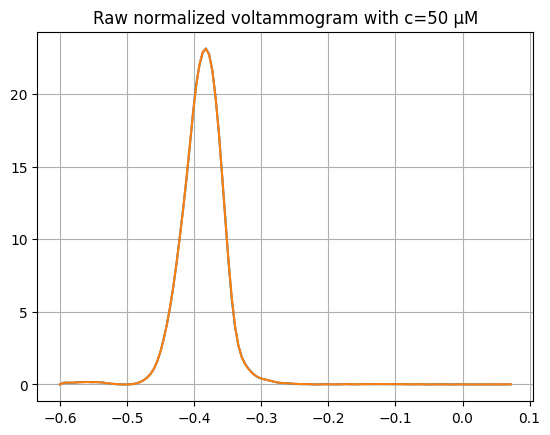

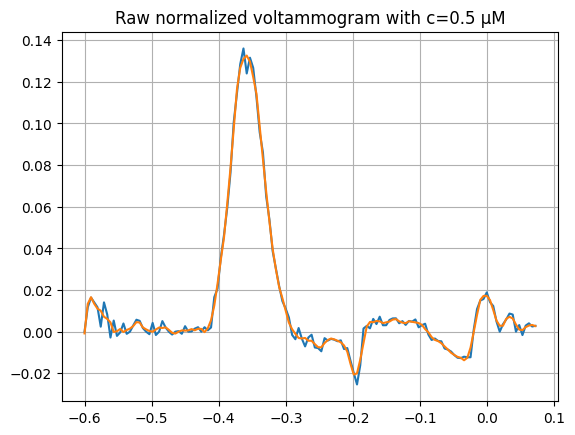

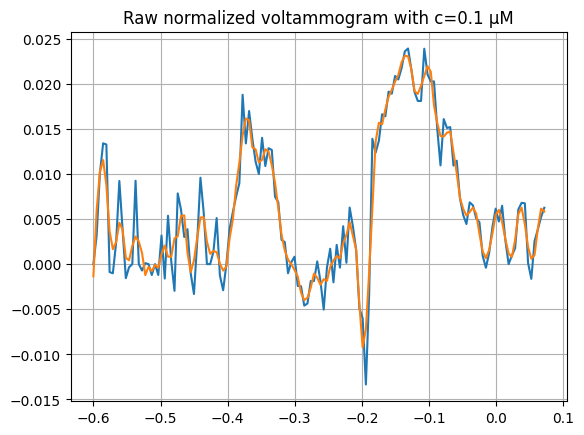

In [6]:
from scipy.signal import savgol_filter

window_length = 7
polyorder = 3

# taking 3 test signals from different concentrations
# c = 50 µM
test_current = currents[5][:140]
smoothed_current = savgol_filter(test_current, window_length=window_length, polyorder=polyorder)
plt.plot(potential[:140], test_current)
plt.plot(potential[:140], smoothed_current[:140])
plt.title(f'Raw normalized voltammogram with c={concentrations[5]} µM')
plt.grid()
plt.show()

# c = 0.5 µM
test_current = normalized_currents[32][:140]
smoothed_current = savgol_filter(test_current, window_length=window_length, polyorder=polyorder)
plt.plot(potential[:140], test_current)
plt.plot(potential[:140], smoothed_current[:140])
plt.title(f'Raw normalized voltammogram with c={concentrations[32]} µM')
plt.grid()
plt.show()

# c = 0.1 µM
test_current = normalized_currents[40][:140]
smoothed_current = savgol_filter(test_current, window_length=window_length, polyorder=polyorder)
plt.plot(potential[:140], test_current)
plt.plot(potential[:140], smoothed_current[:140])
plt.title(f'Raw normalized voltammogram with c={concentrations[40]} µM')
plt.grid()
plt.show()


In [7]:
# smothing all the signals

window_length = 7
polyorder = 3

smoothed_currents: list[np.ndarray] = []
for current in normalized_currents:
    smoothed_current = savgol_filter(current, window_length=window_length, polyorder=polyorder)
    smoothed_currents.append(smoothed_current)

# cleaning up memory
del normalized_currents
del currents

currents = smoothed_currents

# Feature extraction
---
### Category A: Electrochemical Peak Features
- the highest importance

| * | Subcategory   | Feature                   | Details              |
| --- | ------------- | ------------------------- | -------------------- |
| 1. | Peak location | Peak potential ($E_p$)      | Redox potential - the maximum current value |
| 2. | Peak height   | Peak current ($I_p$)        | Concentration proxy  |
| 3. | Peak width    | FWHM                      | Kinetics + diffusion |
| 4. | Peak area     | $\int I dE$                     | Total charge         |
| 5. | Shape         | Left slope | Symmetry             |
| 6. | Shape         | Right slope | Symmetry             |
| 7. | Sharpness     | Second derivative at peak | Reversibility        |
| 8. | Peak ratio    | I_peak / baseline RMS     | SNR                  |



Peak current for concentration 50 µM: 23.101233847561723 µA
Peak potential for concentration 50 µM: -0.382515 V
FWHM for concentration 50 µM: 0.062857 V
Peak area (AUC) for concentration 50 µM: 1.5999427864242244 µA·V


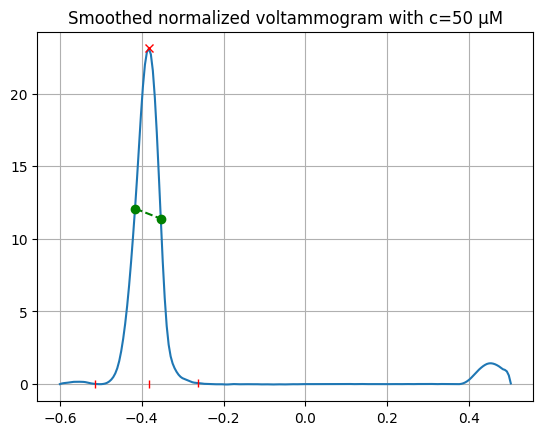

In [10]:
test_current = currents[5]

peak_current = physics.get_peak_current(test_current)
peak_potential = physics.get_peak_potential(potential, test_current)
fwhm = physics.get_peak_width_HM(potential, test_current, peak_current, threshold_ratio=0.5)
auc = physics.get_peak_area(potential, test_current)


print(f'Peak current for concentration {concentrations[5]} µM: {peak_current} µA')
print(f'Peak potential for concentration {concentrations[5]} µM: {peak_potential} V')
print(f'FWHM for concentration {concentrations[5]} µM: {fwhm} V')
print(f'Peak area (AUC) for concentration {concentrations[5]} µM: {auc} µA·V') 
threshold = peak_current * 0.5
indices_above_threshold = np.where(test_current >= threshold)[0]
left_idx = indices_above_threshold[0]
right_idx = indices_above_threshold[-1] + 1
    

plt.plot(
    potential, test_current,
    peak_potential, peak_current, 'rx',
    peak_potential, 0, 'r|',
    potential[left_idx], test_current[left_idx], 'go',
    potential[right_idx], test_current[right_idx], 'go',
    [potential[left_idx], potential[right_idx]], [test_current[left_idx], test_current[right_idx]], 'g--',
    potential[18], test_current[18], 'r|',
    potential[70], test_current[70], 'r|',
)
plt.title(f'Smoothed normalized voltammogram with c={concentrations[5]} µM')
plt.grid()
plt.show()

In [ ]:
from scipy.stats import linregress
import numpy as np

def get_features_category_b(potential, current):
    # index of max current (peak) 
    # we go relative to this point 
    peak_idx = np.argmax(current)

    # defining the three zones based on the peak: baseline, pre-preak and post-peak
    # we consider the first 15 points as baseline 
    baseline_end = 15
    base_slice = slice(0, baseline_end) 

    #extract data
    x_base = potential[base_slice]
    y_base = current[base_slice]

    # 1. Mean Baseline Current: avg of the flat part (before the reaction)
    mean_base = np.mean(y_base)

    # 2. Baseline slope: slope of the baseline (to see if there is a drift / tilt)
    # using linregress
    if len(x_base) > 1:
        slope, intercept, _, _, _ = linregress(x_base, y_base)
        
        # calc residuals (actual - predicted) to find noise
        y_pred = slope * x_base + intercept
        residuals = y_base - y_pred
        # 5. Baseline RMS noise: identify differences between actual point and the linear regression line
        rms_noise = np.sqrt(np.mean(residuals**2))
    else:
        slope = 0
        rms_noise = 0

    # 3. Pre-peak slope: calc how steep the climb is
    pre_start = max(0, peak_idx - 5)
    if peak_idx > pre_start:
        pre_slope, _, _, _, _ = linregress(potential[pre_start:peak_idx], 
                                           current[pre_start:peak_idx])
    else:
        pre_slope = 0

    # 4. post-peak slope: calc how steep the decline is
    post_end = min(len(current), peak_idx + 5)
    if post_end > peak_idx:
        post_slope, _, _, _, _ = linregress(potential[peak_idx:post_end], 
                                            current[peak_idx:post_end])
    else:
        post_slope = 0
    return {
        "Mean_Baseline": mean_base,
        "Baseline_Slope": slope,
        "Baseline_RMS": rms_noise,
        "Pre_Peak_Slope": pre_slope,
        "Post_Peak_Slope": post_slope
    }

In [ ]:
from scipy.stats import linregress
import numpy as np

def get_features_category_b(potential, current):
    # index of max current (peak) 
    # we go relative to this point 
    peak_idx = np.argmax(current)

    # defining the three zones based on the peak: baseline, pre-preak and post-peak
    # we consider the first 15 points as baseline 
    baseline_end = 15
    base_slice = slice(0, baseline_end) 

    #extract data
    x_base = potential[base_slice]
    y_base = current[base_slice]

    # 1. Mean Baseline Current: avg of the flat part (before the reaction)
    mean_base = np.mean(y_base)

    # 2. Baseline slope: slope of the baseline (to see if there is a drift / tilt)
    # using linregress
    if len(x_base) > 1:
        slope, intercept, _, _, _ = linregress(x_base, y_base)
        
        # calc residuals (actual - predicted) to find noise
        y_pred = slope * x_base + intercept
        residuals = y_base - y_pred
        # 5. Baseline RMS noise: identify differences between actual point and the linear regression line
        rms_noise = np.sqrt(np.mean(residuals**2))
    else:
        slope = 0
        rms_noise = 0

    # 3. Pre-peak slope: calc how steep the climb is
    pre_start = max(0, peak_idx - 5)
    if peak_idx > pre_start:
        pre_slope, _, _, _, _ = linregress(potential[pre_start:peak_idx], 
                                           current[pre_start:peak_idx])
    else:
        pre_slope = 0

    # 4. post-peak slope: calc how steep the decline is
    post_end = min(len(current), peak_idx + 5)
    if post_end > peak_idx:
        post_slope, _, _, _, _ = linregress(potential[peak_idx:post_end], 
                                            current[peak_idx:post_end])
    else:
        post_slope = 0
    return {
        "Mean_Baseline": mean_base,
        "Baseline_Slope": slope,
        "Baseline_RMS": rms_noise,
        "Pre_Peak_Slope": pre_slope,
        "Post_Peak_Slope": post_slope
    }